In [12]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [13]:
hallmark = pd.read_excel('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/FW__MCF10A_wild_type_and_PIK3CA_H1047R_knock-in_cell_lines/Supplementary Table S4.xlsx', 
    sheet_name='MCF10A_hallmark_PI3K_Activation')

In [14]:
from utils import Data, get_ppi_edge_list

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [15]:
hallmark_mask = np.load('hallmark_mask.npy')

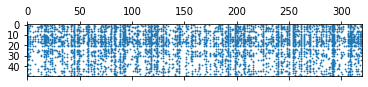

In [334]:
from scipy import sparse


plt.spy(sparse.csr_matrix(hallmark_mask), markersize=0.75)

In [16]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
from pathlib import Path
from tqdm import tqdm
warnings.filterwarnings("ignore")
from sklearn import metrics

import yaml

with open('args.yaml', 'r') as f:
    args_dict = yaml.safe_load(f)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()
args = argparse.Namespace(**args_dict)
args.tf_gene = np.load('tf_gene.npy')

In [18]:
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

daata = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb") )
cancers = daata['idx2can']

from utils import Data 

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

data = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb"))


df = pd.DataFrame(np.column_stack([data['tmr'], data['can']]), columns=['tmr', 'cancer'])
df['cancer'] = df['cancer'].astype(int).replace(data['idx2can'])
xdf = pd.read_parquet('xdf.parquet') 


import gzip

def split_mutants(cancer, gene):    
    if gene is None:
        dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
        idx = xdf[xdf.id.isin(dframe.index)].idx.values
        return idx
        


    _sm = f'SM_{gene}'
    _scna = f'SCNA_{gene}'
    
    if not cancer:
        dframe = data_csv.sga_sga.loc[df.tmr]
    else:
        dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
    
    wt = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 0)]
    sm = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 0)]
    idx = xdf[xdf.id.isin(wt.index)].idx.values
    idy = xdf[xdf.id.isin(sm.index)].idx.values

    return idx, idy
    


f = gzip.GzipFile('sga.npy.gz', 'r')
sga = np.load(f)
f.close()

g = gzip.GzipFile('can.npy.gz', 'r')
can = np.load(g)
g.close()


In [19]:
models = []
for m in tqdm(list(Path('/ix/hosmanbeyoglu/kor11/output').iterdir())):
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    model.load_model(m, device=device)
    model.eval()
    models.append(model)


random_models = []
for m in tqdm(list(Path('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output').glob('random_model*.pth'))):
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    model.load_model(m, device=device)
    model.eval()
    random_models.append(model)

100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


In [20]:
from statsmodels.stats.multitest import fdrcorrection

In [53]:

cancerss = df['cancer'].unique()
cancer_results = []

for cancer in tqdm(cancerss):

    random = None
    nonrandom = None
    
    for model in random_models:
        model.eval()

        X = torch.from_numpy(sga)[split_mutants(cancer, None)]
        C = torch.from_numpy(can)[split_mutants(cancer, None)]
        r = model(X, C, pathways=True).data.numpy()

        if random is None:
            random = r
        else:
            random += r



    for model in models:
        model.eval()

        X = torch.from_numpy(sga)[split_mutants(cancer, None)]
        C = torch.from_numpy(can)[split_mutants(cancer, None)]
        s = model(X, C, pathways=True).data.numpy()

        if nonrandom is None:
            nonrandom = s
        else:
            nonrandom += s


    random = random / len(random_models)
    nonrandom = nonrandom / len(models)
    cancer_results.append([Counter(fdrcorrection(ttest_1samp(random[:, i], random[:, i][:]).pvalue)[0])[True]/len(random) for i in range(50)])



100%|██████████| 17/17 [01:52<00:00,  6.63s/it]


In [61]:
(1-pd.DataFrame(cancer_results, index=cancerss, columns=hallmark.Description.values).T).to_csv('pathway_heatmap.csv')

In [69]:
import matplotlib.pyplot as plt

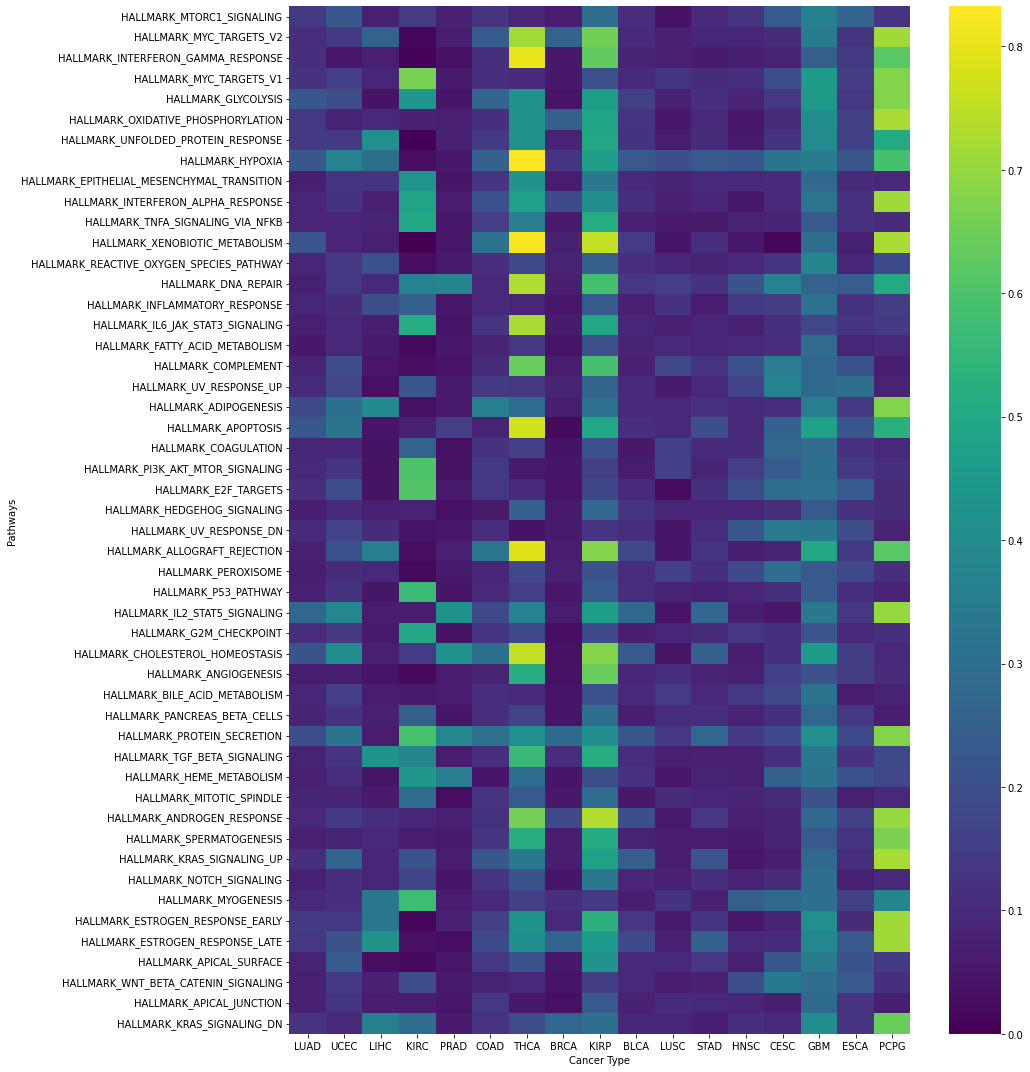

In [88]:
plt.figure(figsize=(15, 15))
pdf = pd.read_csv('pathway_heatmap.csv').set_index('Unnamed: 0')
pdf.index.name='Pathways'
sns.heatmap(pdf, cmap='viridis', square=False)
plt.ylabel('Pathways')
plt.xlabel('Cancer Type')
plt.tight_layout()

plt.savefig('heatmap.png', dpi=300)
plt.show()


In [50]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
import seaborn as sns

from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [22]:
clinical_from_cbioportal = pd.read_table('https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/hnsc_tcga_pan_can_atlas_2018/data_clinical_patient.txt')
clinical_from_cbioportal = clinical_from_cbioportal.drop([0, 1, 2, 3])
clinical_from_cbioportal = clinical_from_cbioportal.set_index('#Patient Identifier')
traits = clinical_from_cbioportal[['Subtype']].copy()
traits.index.name = None
traits.columns = ['hpv']
traits = traits.dropna()
traits.hpv = traits.hpv.replace({'HNSC_HPV-': 0, 'HNSC_HPV+': 1})

idx = xdf[xdf.id.isin(traits[traits.hpv==1].index)].idx.values
idy = xdf[xdf.id.isin(traits[traits.hpv==0].index)].idx.values

In [31]:
from tqdm import tqdm

In [53]:
R = None
S = None

for model in tqdm(models):
    model.eval()

    X = torch.from_numpy(sga)[idx]
    C = torch.from_numpy(can[idx])
    r = model(X, C, pathways=True).data.numpy()

    if R is None:
        R = r
    else:
        R += r

    X = torch.from_numpy(sga)[idy]
    C = torch.from_numpy(can[idy])
    s = model(X, C, pathways=True).data.numpy()

    if S is None:
        S = s
    else:
        S += s    

100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


In [65]:
dx.columns

Index(['pvalue'], dtype='object')

In [72]:
dx = pd.DataFrame(ttest_ind(R, S).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True)

# dx.to_csv('./NFE2L2.csv')

In [33]:
R = R / len(models)
S = S / len(models)

p_predicted = pd.DataFrame(ttest_ind(R, S).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True).loc[hallmark.Description].pvalue.values

p_exp = hallmark['pvalue'].values
spearmanr(p_predicted, p_exp)

SpearmanrResult(correlation=-0.07645024980002056, pvalue=0.5977177899674204)

In [11]:
import numpy as np
import pandas as pd

In [23]:
from tqdm import tqdm
from pathlib import Path
import pickle 

run = list()

for d in tqdm(list(Path('/ix/hosmanbeyoglu/kor11/CITRUS_PKL').glob('*.pkl'))):
    dataset = pickle.load( open(d, "rb") )
    run.append(dataset) 
    
tfs = list()
for i in range(len(run)):
    tfs.append(run[i]["hid_tmr"])

tf_ensemble = 0
for i in range(len(run)):
    tf_ensemble += tfs[i]
    
tf_ensemble = tf_ensemble/len(run)

100%|██████████| 13/13 [00:35<00:00,  2.77s/it]


In [25]:
pd.DataFrame(tf_ensemble).iloc[split_mutants('BRCA', None)]

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
8,0.724059,-0.345777,0.533876,0.274598,-0.216675,0.741299,-0.191870,0.073369,0.504060,0.265650,...,-0.772245,-0.442598,-0.731769,0.216854,0.381547,0.195883,0.415247,0.845829,-0.321920,0.239764
25,0.799076,-0.363978,0.474229,0.131638,-0.288875,0.845225,-0.139799,0.072042,0.416422,0.109785,...,-0.641740,-0.577534,-0.776019,0.209670,0.310812,0.326084,0.297525,1.112511,-0.413679,0.163640
33,0.630442,-0.342871,0.442607,0.217076,-0.271857,0.778734,-0.249646,0.012957,0.550132,0.130122,...,-0.508508,-0.413839,-0.663965,0.223625,0.286649,0.075163,0.426995,0.716764,-0.324654,0.294979
35,0.316574,-0.611317,0.094221,0.019382,-0.215554,1.021958,-0.003361,-0.106718,0.578056,0.457875,...,-0.500437,-0.096140,-0.556799,0.159318,0.214532,0.211188,0.974130,0.667016,-0.041272,0.340927
37,0.621495,-0.385567,0.295777,0.201740,-0.294825,1.282272,-0.020725,0.088449,0.377462,0.004710,...,-0.672029,-0.375155,-0.717200,0.223117,0.317477,0.190096,0.739546,0.951125,-0.282254,0.208477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,0.638325,-0.440274,0.358625,0.185809,-0.352990,1.380663,-0.157253,0.148165,0.551628,0.032013,...,-0.555230,-0.373554,-0.590118,0.106041,0.309127,0.226812,0.810398,0.806068,-0.370461,0.178743
4615,0.529161,-0.265350,0.336692,0.082009,-0.184504,0.623915,-0.079366,0.020346,0.347692,0.300064,...,-0.568785,-0.481278,-0.666045,0.173187,0.136652,0.227933,0.270746,0.829084,-0.198004,0.202158
4618,0.288261,-0.161690,0.295936,0.095132,-0.295854,1.150134,-0.103112,0.006895,0.424984,0.170083,...,-0.549821,-0.467286,-0.735134,0.218477,0.350273,0.113049,0.759140,0.789518,-0.272559,0.147998
4620,0.599857,-0.351496,0.290445,0.042431,-0.187098,1.063681,-0.051042,0.114153,0.356304,0.269035,...,-0.746522,-0.381131,-0.720233,0.233318,0.138772,0.239691,0.471016,1.067172,-0.229864,0.195996


In [ ]:
import pandas as pd
import dash_bio
df_tf = pd.read_csv('df_tf.csv', index_col=0)

In [193]:
# cancerss = df['cancer'].unique()
# cancer_results = []
# cancer_results2 = []
# cancer_results3 = []


# for cancer in tqdm(cancerss):

#     random = None
#     nonrandom = None
    
#     for model in random_models:
#         model.eval()

#         X = torch.from_numpy(sga)[split_mutants(cancer, None)]
#         C = torch.from_numpy(can)[split_mutants(cancer, None)]
#         preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt = model(X, C, pathways=False)
#         r = hid_tmr.data.numpy()


#         if random is None:
#             random = r
#         else:
#             random += r



#     for model in models:
#         model.eval()

#         X = torch.from_numpy(sga)[split_mutants(cancer, None)]
#         C = torch.from_numpy(can)[split_mutants(cancer, None)]
#         preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt = model(X, C, pathways=False)
#         s = hid_tmr.data.numpy()


#         if nonrandom is None:
#             nonrandom = s
#         else:
#             nonrandom += s


#     random = random / len(random_models)
#     nonrandom = nonrandom / len(models)
#     cancer_results.append([Counter(fdrcorrection(ttest_1samp(random[:, i], random[:, i][:]).pvalue)[0])[True]/len(random) for i in range(hid_tmr.shape[1])])
#     cancer_results2.append([Counter(fdrcorrection(ttest_1samp(nonrandom[:, i], nonrandom[:, i][:]).pvalue)[0])[True]/len(random) for i in range(hid_tmr.shape[1])])




100%|██████████| 17/17 [04:01<00:00, 14.19s/it]


(346, 18)

In [233]:
wt_values = df_tf[['CDC5L']].values[[wt]].reshape(-1)
sm_valuesdf_tf[['CDC5L']].values[[sm]].reshape(-1))

In [235]:
wt_values.mean() - sm_values.mean

-0.12829958731856128

In [228]:
df_tf[['CDC5L']].values[[wt]].reshape(-1)

(573,)

In [237]:
wt, sm = split_mutants(cancer='HNSC', gene='NFE2L2')

effect_size = wt_values.mean() - sm_values.mean()

tf = 'TP53'
wt_values = df_tf[[tf]].values[[wt]].reshape(-1)
sm_values = df_tf[[tf]].values[[sm]].reshape(-1)

ttest_ind(wt_values, sm_values)

Ttest_indResult(statistic=-3.96031014718891, pvalue=9.014354280472099e-05)

In [284]:
from scipy.stats import mannwhitneyu

In [313]:
volcanos = []

for cancer in tqdm(cancerss):
    e_values = []
    p_values = []
    f_values = []
    tf_values = []

    wt, sm = split_mutants(cancer=cancer, gene='NFE2L2')


    for tf in data_csv.tf:

        wt_values = df_tf[[tf]].values[[wt]].reshape(-1)
        sm_values = df_tf[[tf]].values[[sm]].reshape(-1)
        # effect_size = wt_values.mean() - sm_values.mean()


        if len(wt_values) > 1 and len(sm_values) > 1 :

            # pval = ttest_ind(wt_values, sm_values).pvalue
            pval = float(mannwhitneyu(wt_values, sm_values).pvalue)
            p_values.append(pval)
            e_values.append(float(wt_values.mean()-sm_values.mean()))
            tf_values.append(tf)

            
            
    p_values = np.array(p_values)
    e_values = np.array(e_values)


    volcano = pd.DataFrame([p_values.astype(float), e_values.astype(float), tf_values]).T
    volcano['FDR'] = fdrcorrection(p_values)[1]
    volcano.columns = ['P', 'EFFECTSIZE', 'TF', 'FDR']
    # volcano['EFFECTSIZE'] = np.log10(tf_volcano['EFFECTSIZE'])
    volcano['SNP'] = ''
    volcano['GENE'] = tf_values

    volcano['P'] = volcano['P'].astype(float)
    volcano['EFFECTSIZE'] = volcano['EFFECTSIZE'].astype(float)


    volcanos.append(volcano)


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


In [315]:
for v,c  in zip(volcanos, cancerss):
    v.to_csv(f'NFE2L2_{c}.csv')

In [314]:
pp = 'P'
dash_bio.VolcanoPlot(dataframe=volcanos[0], 
                point_size=7,
                p=pp,
                # xlabel=f'Mean Difference',
                # ylabel=f'-log10({pp})',
                # title=f'Inferred TF activity {data_csv.tf[1]} mutant vs wild-type',
            )

In [276]:
help(dash_bio.VolcanoPlot)

Help on function VolcanoPlot in module dash_bio.component_factory._volcano:

VolcanoPlot(dataframe, effect_size='EFFECTSIZE', p='P', snp='SNP', gene='GENE', annotation=None, logp=True, xlabel=None, ylabel='-log10(p)', point_size=5, col=None, effect_size_line=None, effect_size_line_color='grey', effect_size_line_width=0.5, genomewideline_value=7.301029995663981, genomewideline_color='grey', genomewideline_width=1, highlight=True, highlight_color='red', **kwargs)
    Return a Dash Bio VolcanoPlot figure.
    
    Keyword arguments:
    - dataframe (dataframe; required): A pandas dataframe which must contain at
        least the following two columns:
                - a numeric quantity to plot such as a p-value or zscore
                - a numeric quantity measuring the strength of association,
                  typically an odds ratio, regression coefficient, or log fold
                  change. Here, it is referred to as `effect_size`.
    - effect_size (string; default 'EFFECTSIZE'

In [ ]:
cancerss = df['cancer'].unique()
cancer_results = []
cancer_results2 = []
cancer_results3 = []


for cancer in tqdm(cancerss):

    random = None
    nonrandom = None
    
    for model in random_models:
        model.eval()

        X = torch.from_numpy(sga)[split_mutants(cancer, None)]
        C = torch.from_numpy(can)[split_mutants(cancer, None)]
        preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt = model(X, C, pathways=False)
        r = hid_tmr.data.numpy()


        if random is None:
            random = r
        else:
            random += r



    for model in models:
        model.eval()

        X = torch.from_numpy(sga)[split_mutants(cancer, None)]
        C = torch.from_numpy(can)[split_mutants(cancer, None)]
        preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt = model(X, C, pathways=False)
        s = hid_tmr.data.numpy()


        if nonrandom is None:
            nonrandom = s
        else:
            nonrandom += s


    random = random / len(random_models)
    nonrandom = nonrandom / len(models)
    cancer_results.append([Counter(fdrcorrection(ttest_1samp(random[:, i], random[:, i][:]).pvalue)[0])[True]/len(random) for i in range(hid_tmr.shape[1])])
    cancer_results2.append([Counter(fdrcorrection(ttest_1samp(nonrandom[:, i], nonrandom[:, i][:]).pvalue)[0])[True]/len(random) for i in range(hid_tmr.shape[1])])


In [194]:
random = np.array(random)
nonrandom = np.array(nonrandom)

In [195]:
pvalues = ttest_ind(random[:, :], nonrandom[:, :]).pvalue
fdr = fdrcorrection(pvalues)
effectsize = (abs(random) / abs(nonrandom)).mean(0)


In [117]:
# plt.figure(figsize=(10, 45))
# # pdf = pd.read_csv('pathway_heatmap.csv').set_index('Unnamed: 0')
# pdf = 1-pd.DataFrame(cancer_results2, index=cancerss, columns=data_csv.tf).T
# pdf.index.name='Transcription Factors'
# sns.heatmap(pdf, cmap='viridis', square=False, yticklabels=True)
# plt.ylabel(pdf.index.name)
# plt.xlabel('Cancer Type')
# plt.tight_layout()

# plt.savefig('heatmap_tf.png', dpi=300)
# plt.show()


In [205]:
df = pd.DataFrame(np.column_stack([daata['tmr'], daata['can']]), columns=['tmr', 'cancer'])
df['cancer'] = df['cancer'].astype(int).replace(daata['idx2can'])

def split_mutants2(cancer, gene):    
    _sm = f'SM_{gene}'
    _scna = f'SCNA_{gene}'

    if cancer is None:
        dframe = data_csv.sga_sga.loc[df.tmr]

    else:
        dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
    
    wt = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 0)]
    sm = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 0)]
    scna = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 1)]
    sm_scna = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 1)]
    
    return wt.index.values, sm.index.values, scna.index.values, sm_scna.index.values

In [201]:
pvalues = ttest_ind(random[:, :], nonrandom[:, :]).pvalue
fdr = fdrcorrection(pvalues)
effectsize = (abs(random) / abs(nonrandom)).mean(0)


tf_volcano = pd.DataFrame([fdr[1], effectsize]).T
tf_volcano.columns = ['P', 'EFFECTSIZE']
tf_volcano['EFFECTSIZE'] = np.log10(tf_volcano['EFFECTSIZE'])
tf_volcano['SNP'] = ''
tf_volcano['GENE'] = hallmark.Description
tf_volcano.head(3)

,P,EFFECTSIZE,SNP,GENE
0,2.003061e-210,-0.555415,,HALLMARK_MTORC1_SIGNALING
1,1.256923e-182,-0.177555,,HALLMARK_MYC_TARGETS_V2
2,5.126659e-217,-0.244459,,HALLMARK_INTERFERON_GAMMA_RESPONSE


In [202]:
dash_bio.VolcanoPlot(dataframe=tf_volcano, 
                point_size=7,
            )

In [ ]:
tf_volcano.to_csv('pathway_volcano.csv', index=None)